## **Required libraries**: 

In [63]:
# Just run this block. Please do not modify the following code.
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim

# Torchtest package
import torchtext
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
from torch.nn.utils.rnn import pad_sequence

# Tqdm progress bar
from tqdm import tqdm_notebook, tqdm

# Code provide to you for training and evaluation
from utils import train, evaluate, set_seed_nb, unit_test_values, deterministic_init, plot_curves

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [65]:
# load checkers
d1 = torch.load('./data/d1.pt')
d2 = torch.load('./data/d2.pt')
d3 = torch.load('./data/d3.pt')
d4 = torch.load('./data/d4.pt')

## **Preprocess Data**

In [66]:
MAX_LEN = 20
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [67]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_.lower()))
  return vocab(counter, specials=['<unk>', '<pad>', '<sos>', '<eos>'], min_freq=2)


de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)
de_vocab.set_default_index(de_vocab['<unk>'])
en_vocab.set_default_index(en_vocab['<unk>'])

In [68]:
def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    raw_en_l=raw_en.lower()     #turn sentences to lower case
    raw_de_l=raw_de.lower()
    de_tensor = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de_l)],
                            dtype=torch.long)
    en_tensor = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en_l)],
                            dtype=torch.long)
    if len(de_tensor) <= MAX_LEN-2 and len(en_tensor) <= MAX_LEN-2:
        data.append((de_tensor, en_tensor))
  return data

In [69]:
train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [70]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
SOS_IDX = de_vocab['<sos>']
EOS_IDX = de_vocab['<eos>']

In [71]:
def generate_batch(data_batch):

    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
          en_batch.append(torch.cat([torch.tensor([SOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
          de_batch.append(torch.cat([torch.tensor([SOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    fix=torch.ones(MAX_LEN,en_batch.shape[1])
    two= pad_sequence([de_batch,en_batch, fix], padding_value=PAD_IDX)
    de_batch=two[:,0,]
    en_batch=two[:,1,]
    return de_batch, en_batch

In [72]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=False, collate_fn=generate_batch)

In [73]:
# Get the input and the output sizes for model
input_size = len(de_vocab)
output_size = len(en_vocab)
print (input_size,output_size)

7854 5894


In [74]:
def train_and_plot (model, optimizer, scheduler, criterion, filename):
  train_perplexity_history = []
  valid_perplexity_history = []

  for epoch_idx in range(EPOCHS):
      print("-----------------------------------")
      print("Epoch %d" % (epoch_idx+1))
      print("-----------------------------------")

      train_loss, avg_train_loss = train(model, train_loader, optimizer, criterion, device=device)
      scheduler.step(train_loss)

      val_loss, avg_val_loss = evaluate(model, valid_loader, criterion, device=device)

      train_perplexity_history.append(np.exp(avg_train_loss))
      valid_perplexity_history.append(np.exp(avg_val_loss))

      print("Training Loss: %.4f. Validation Loss: %.4f. " % (avg_train_loss, avg_val_loss))
      print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " % (np.exp(avg_train_loss), np.exp(avg_val_loss)))

  plot_curves(train_perplexity_history, valid_perplexity_history, filename)

## **Train a Transformer**

We will be implementing a one-layer Transformer **encoder** 

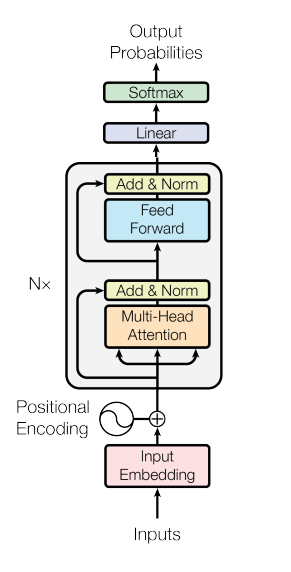

In [75]:
Image(filename="imgs/encoder.png")

You can refer to the [original paper](https://arxiv.org/pdf/1706.03762.pdf) for more details.

## Load the preprocessed data


In [76]:
train_inxs = np.load('./data/train_inxs.npy')
val_inxs = np.load('./data/val_inxs.npy')
train_labels = np.load('./data/train_labels.npy')
val_labels = np.load('./data/val_labels.npy')

# load dictionary
word_to_ix = {}
with open("./data/word_to_ix.csv", "r", encoding='utf-8') as f:
    reader = csv.reader(f)
    for line in reader:
        word_to_ix[line[0]] = line[1]
print("Vocabulary Size:", len(word_to_ix))

print(train_inxs.shape) # 7000 training instances, of (maximum/padded) length 43 words.
print(val_inxs.shape) # 1551 validation instances, of (maximum/padded) length 43 words.
print(train_labels.shape)
print(val_labels.shape)

d1 = torch.load('./data/d1.pt')
d2 = torch.load('./data/d2.pt')
d3 = torch.load('./data/d3.pt')
d4 = torch.load('./data/d4.pt')

Vocabulary Size: 1542
(7000, 43)
(1551, 43)
(7000,)
(1551,)


## **Embeddings**




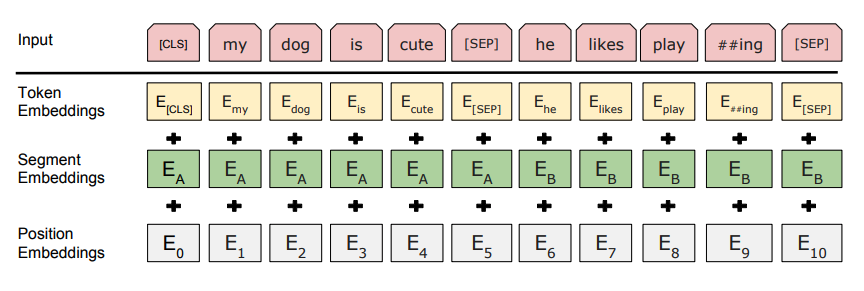

In [77]:
Image(filename="imgs/embedding.png")

In [78]:
from models.Transformer import TransformerTranslator
inputs = train_inxs[0:2]
inputs = torch.LongTensor(inputs)

model = TransformerTranslator(input_size=len(word_to_ix), output_size=2, device=device, hidden_dim=128, num_heads=2, dim_feedforward=2048, dim_k=96, dim_v=96, dim_q=96, max_length=train_inxs.shape[1])

embeds = model.embed(inputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(embeds, d1)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

Difference: 0.0010500667849555612


## **Multi-head Self-Attention**



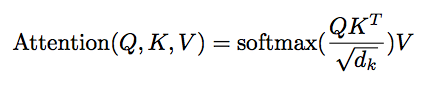

In [79]:
Image(filename="imgs/attn.png")

We want to have multiple self-attention operations, computed in parallel. Each of these is called a *head*. We concatenate the heads and multiply them with the matrix `attention_head_projection` to produce the output of this layer.


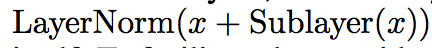

In [80]:
Image(filename="imgs/layer_norm.png")

In [81]:
hidden_states = model.multi_head_attention(embeds)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(hidden_states, d2)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

Difference: 0.0009964046766981483


## **Element-Wise Feed-forward Layer**


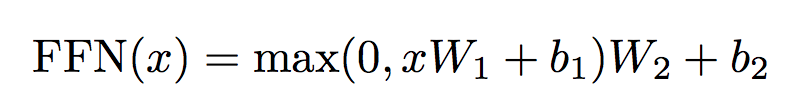

In [82]:
Image(filename="imgs/ffn.png")

In [83]:
outputs = model.feedforward_layer(hidden_states)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(outputs, d3)).item()) # should be very small (<0.01)
except:
    print("NOT IMPLEMENTED")

Difference: 0.0009992647683247924


## **Final Layer**


In [84]:
print(outputs.shape)

torch.Size([2, 43, 128])


In [85]:

scores = model.final_layer(outputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(scores, d4)).item()) # should be very small (<3e-4)
except:
    print("NOT IMPLEMENTED")

Difference: 0.0001246812753379345


In [86]:
inputs = train_inxs[0:2]
inputs = torch.LongTensor(inputs)
inputs.to(device)
outputs = model.forward(inputs)

try:
    print("Difference:", torch.sum(torch.pairwise_distance(outputs, scores)).item()) # should be very small (<3e-4)
except:
    print("NOT IMPLEMENTED")

Difference: 0.00012162235361756757


## **Train the Transformer**


In [87]:
# Hyperparameters
learning_rate = 1e-3
EPOCHS = 10

# Model
trans_model = TransformerTranslator(input_size, output_size, device, max_length = MAX_LEN).to(device)

# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(trans_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
filename='trans_model'
train_and_plot(trans_model, optimizer, scheduler, criterion, filename)

-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 4.2050. Validation Loss: 3.5490. 
Training Perplexity: 67.0216. Validation Perplexity: 34.7783. 
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.4905. Validation Loss: 3.2751. 
Training Perplexity: 32.8039. Validation Perplexity: 26.4454. 
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 3.1945. Validation Loss: 3.1111. 
Training Perplexity: 24.3984. Validation Perplexity: 22.4462. 
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 2.9609. Validation Loss: 3.0117. 
Training Perplexity: 19.3161. Validation Perplexity: 20.3220. 
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 2.7695. Validation Loss: 2.9491. 
Training Perplexity: 15.9502. Validation Perplexity: 19.0896. 
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training Loss: 2.6099. Validation Loss: 2.9152. 
Training Perplexity: 13.5973. Validation Perplexity: 18.4528. 
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/190 [00:00<?, ?it/s]